In [2]:
## first time series test

# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex
import fastparquet # fast read/write for large data structures
import sklearn.preprocessing as pre # for data normalisation
from sklearn.metrics import pairwise_distances

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 
import matplotlib.image as mplimg

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)

from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [3]:
# INPUT_CSV = '/Users/markbemelmans/Documents/PhD/projects/Merapi2021/TSX/staring_134/h5_file_ts_win13.csv'

INPUT_CSV = '/Users/markbemelmans/Documents/PhD/projects/Merapi2021/CSK/dsc1/h5_file_ts_win13.csv'


NAN_FRAC_TRESH = 0

(323032, 322)


(array([262958., 270919., 273671., 280543., 282132., 284291., 285973.,
        286848., 288213., 288780., 289707., 290535., 290967., 291663.,
        291997., 292609., 293208., 293486., 294110., 295054., 295710.,
        296035., 296702., 297891., 298208., 298842., 299112., 299693.,
        300321., 301237., 301861., 302171., 302750., 303333., 303604.,
        304120., 304395., 304843., 305284., 305523., 305925., 306129.,
        306480., 306653., 306994., 307320., 307488., 307857., 308027.,
        308346., 309376., 310265., 311421., 311606., 311973., 312360.,
        312532., 312898., 313061., 313382., 314220., 314591., 314969.,
        315135., 317498., 317678., 317956., 318186., 318295., 318491.,
        318586., 318777., 318928., 319008., 319154., 319216., 319360.,
        319508., 319587., 319708., 319786., 319927., 319985., 320082.,
        320210., 320253., 320360., 320435., 320572., 320709., 320784.,
        320950., 321035., 321183., 321397., 321508., 321815., 322015.,
      

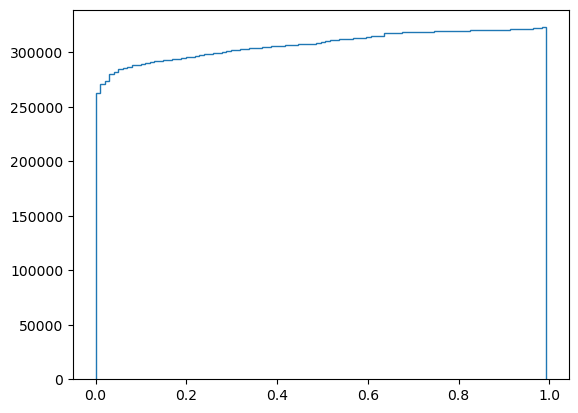

In [4]:
# load data
df = pd.read_csv(INPUT_CSV)
print(np.shape(df))

# compute nan_fraction
disp_data = df.iloc[:,2:]
n_nans = np.sum(np.isnan(disp_data),axis=1)
nan_frac = n_nans/np.shape(disp_data)[1]

# plot cumulative distribution for nan_frac

fig, ax = plt.subplots(1,1)

ax.hist(nan_frac, 100, histtype="step",
                               cumulative=True, label="Cumulative histogram")


In [5]:
# remove data with too many NaNs
df['NaN_frac'] = nan_frac
filt_df = df

# if you want to filter on nan_fraction this is the chance
# filt_df = df[df.NaN_frac<=NAN_FRAC_TRESH]

In [6]:
# make design matrix

def get_date_list(df):
    columns = df.columns
    range_names = columns[2::2]
    date1 = [name[14:22] for name in range_names]
    date2 = [name[24:32] for name in range_names]
    return date1, date2

def get_design_mat(date0,date1):
    unique_dates = np.unique(np.union1d(date0,date1))
    # print(len(date0))
    # print(len(unique_dates))
    A = np.zeros([len(date0),len(unique_dates)-1])
    for dates in enumerate(zip(date0,date1)):
#         print(unique_dates)
#         print(dates[1][0])
        # print(np.where(unique_dates==dates[1][0])[0][0])
        A[dates[0],np.where(unique_dates==dates[1][1])[0][0]-1] = 1
        if np.where(unique_dates==dates[1][0])[0][0]!=0:
            A[dates[0],np.where(unique_dates==dates[1][0])[0][0]-1] = -1
    
    return A[:-1,1:]
    
def get_design_mat_per_point(date0,date1,disp):
    A = get_design_mat(date0,date1)
    nan_idx = np.argwhere(np.isnan(disp.to_numpy())==True)
    # print(nan_idx)
    for idx in nan_idx:
        A[idx,:] = 0
    return A


date1, date2 = get_date_list(filt_df)

A = get_design_mat(date1,date2)  
A_point = get_design_mat_per_point(date1,date2,filt_df.iloc[70000,2::2])  
print(A)
print(A_point)

rank_list = []
for p in filt_df.iterrows():
    print(p[0])
    A_p = get_design_mat_per_point(date1,date2,p[1].iloc[2:-1:2]) 
    rank_list.append(np.linalg.matrix_rank(A_p))


[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ... -1.  0.  1.]
 [ 0.  0.  0. ...  0. -1.  1.]]
[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ... -1.  0.  1.]
 [ 0.  0.  0. ...  0. -1.  1.]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
18

/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_58538/1003935971.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  A[dates[0],np.where(unique_dates==dates[1][0])[0][0]-1] = -1


IndexError: index 0 is out of bounds for axis 0 with size 0

In [6]:
# select data with full rank (i.e. 14 for TSX)

# calculate rank of full matrix
full_rank = np.linalg.matrix_rank(A)
print(np.shape(rank_list))
# add rank list to df
filt_df['Rank'] = np.array(rank_list)

# show number of points without rank deficiency (i.e. part of 1 connected small-baseline network)
print(np.size(np.argwhere(np.array(rank_list)==full_rank)))

filt_df2 = filt_df[filt_df.Rank==full_rank]
# print(filt_df)
print(np.shape(filt_df2))
NAN_FRAC_TRESH = 0
nan_filt_df = filt_df[filt_df.NaN_frac<=NAN_FRAC_TRESH]
print(np.shape(nan_filt_df))


(323032,)
282270
(282270, 324)
(253395, 324)


In [121]:
%matplotlib osx
# show coverage
plt.close('all')
nan_filt_df = df[df.NaN_frac<=0]

fig, ax = plt.subplots(1,1)
ax.scatter(filt_df2['Longitude'],filt_df2['Latitude'],s=10,c=filt_df2['Range_offset_x20201116_x20201127'])

fig, ax = plt.subplots(1,1)
ax.scatter(filt_df['Longitude'],filt_df['Latitude'],s=10,c=filt_df['Range_offset_x20201116_x20201127'])

fig, ax = plt.subplots(1,1)
ax.scatter(nan_filt_df['Longitude'],nan_filt_df['Latitude'],s=10,c=nan_filt_df['Range_offset_x20201116_x20201127'])



In [7]:
# solve least squares for non-rank deficient points

def run_LS_A_inversion(df,disp_ts,date1, date0, A=[], r_a = 'r', prog_mod=5000):
    if r_a == 'r':
        disp_data = df.iloc[:,2:-2:2]
    elif r_a == 'a':
        disp_data = df.iloc[:,3:-2:2]
    else:
        print("ERROR: wrong value for r_a, options are 'r' or 'a'.")


    for i, (index,point) in enumerate(disp_data.iterrows()):
        if np.mod(i,prog_mod)==0:
            print(f'fraction complete:({i}/{np.shape(df)[0]}) = ',round(i/(np.shape(df)[0]))) # progress tracker)
        # B = [0] + point[:-1].to_list()
        # if df.iloc[i,-2] !=0:
        #     nan_idx = np.isnan(point)

        if not A:
            A_p = get_design_mat_per_point(date1,date2,point) 
        else:
            A_p = A

        B = point.to_list()
        nan_idx = np.isnan(B)
        B_sel = np.array(B)[np.argwhere(nan_idx==False)]
        A_p_sel = A_p[np.argwhere(nan_idx==False),:].squeeze()
        
        ts = np.linalg.lstsq(A_p_sel, B_sel, rcond=None)[0]
        disp_ts[i,:] = np.insert(ts,0,0)
    return disp_ts

n_points = np.shape(filt_df2)[0]
rdisp_ts = np.empty(shape=(n_points, A.shape[1]+1), dtype=float) # pre-alloc nd-array
adisp_ts = np.empty(shape=(n_points, A.shape[1]+1), dtype=float) # pre-alloc nd-array
print(np.shape(rdisp_ts))
unique_dates = pd.to_datetime(np.unique(np.union1d(date1,date2)))

run_LS_A_inversion(filt_df2, rdisp_ts, date1,date2, A=[], r_a='r', prog_mod=5000)
run_LS_A_inversion(filt_df2, adisp_ts, date1,date2, A=[], r_a='a', prog_mod=5000)

(282270, 55)
fraction complete: 0.0
fraction complete: 0.017713536684734472
fraction complete: 0.035427073369468945
fraction complete: 0.053140610054203424
fraction complete: 0.07085414673893789
fraction complete: 0.08856768342367237
fraction complete: 0.10628122010840685
fraction complete: 0.12399475679314131
fraction complete: 0.14170829347787578
fraction complete: 0.15942183016261027
fraction complete: 0.17713536684734474
fraction complete: 0.1948489035320792
fraction complete: 0.2125624402168137
fraction complete: 0.23027597690154816
fraction complete: 0.24798951358628263
fraction complete: 0.2657030502710171
fraction complete: 0.28341658695575156
fraction complete: 0.3011301236404861
fraction complete: 0.31884366032522055
fraction complete: 0.336557197009955
fraction complete: 0.3542707336946895
fraction complete: 0.37198427037942394
fraction complete: 0.3896978070641584
fraction complete: 0.40741134374889293
fraction complete: 0.4251248804336274
fraction complete: 0.4428384171183

array([[ 0.00000000e+00, -2.09528652e-01, -7.96953189e-02, ...,
        -4.54071502e-01, -3.84435111e-01, -4.36037337e-01],
       [ 0.00000000e+00, -2.65028997e-01, -8.26123301e-02, ...,
        -5.90191019e-01, -5.30837134e-01, -5.48515838e-01],
       [ 0.00000000e+00, -5.90533550e-01, -3.53533550e-01, ...,
        -7.56375777e-01, -6.68256961e-01, -7.33361782e-01],
       ...,
       [ 0.00000000e+00,  4.09400103e-01, -9.03998968e-02, ...,
         8.73708111e-02,  4.71859724e-02,  5.56374431e-04],
       [ 0.00000000e+00,  1.36390877e-01, -7.32091231e-02, ...,
         5.45099922e-01,  5.20491511e-01,  5.09952036e-01],
       [ 0.00000000e+00,  1.23829755e+00,  1.25897380e+00, ...,
        -2.20486298e+00, -2.16182280e+00, -2.35556040e+00]])

In [9]:
# save time series inversion results
TS_OUTPUT_FILE = '/Users/markbemelmans/Documents/PhD/projects/Merapi2021/CSK/dsc1/h5_file_win13_ts_inv.csv'

unique_date_str = np.unique(np.union1d(date1,date2))
# columns = ['Longitude','Latitude']

# columns.append([[f'r_disp_{date}',f'a_disp_{date}'] for date in unique_date_str]) # each range and azimuth offset pair stay together
# columns.append([f'a_disp_{date}' for date in unique_date_str]) # for azimuth disp
# print(columns)

df_ts = filt_df2.iloc[:,0:2]
print(df_ts)

for col_id in range(np.shape(rdisp_ts)[1]):
    df_ts[f'r_disp_{unique_date_str[col_id]}'] = rdisp_ts[:,col_id]
    df_ts[f'a_disp_{unique_date_str[col_id]}'] = adisp_ts[:,col_id]
print(df_ts)

df_ts.to_csv(TS_OUTPUT_FILE)

         Longitude  Latitude
0       110.483566 -7.519673
1       110.483627 -7.519764
2       110.483574 -7.519828
3       110.483536 -7.519897
4       110.483505 -7.519970
...            ...       ...
310758  110.418274 -7.561081
310761  110.427368 -7.509089
310764  110.418236 -7.561071
310765  110.418282 -7.561155
310775  110.418449 -7.560341

[282270 rows x 2 columns]


/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_51928/2131288111.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ts[f'a_disp_{unique_date_str[col_id]}'] = adisp_ts[:,col_id]
/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_51928/2131288111.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ts[f'r_disp_{unique_date_str[col_id]}'] = rdisp_ts[:,col_id]
/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_51928/2131288111.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usua

         Longitude  Latitude  r_disp_  a_disp_  r_disp_20200910  \
0       110.483566 -7.519673      0.0      0.0        -0.081862   
1       110.483627 -7.519764      0.0      0.0        -0.110186   
2       110.483574 -7.519828      0.0      0.0        -0.116883   
3       110.483536 -7.519897      0.0      0.0        -0.141539   
4       110.483505 -7.519970      0.0      0.0        -0.152580   
...            ...       ...      ...      ...              ...   
310758  110.418274 -7.561081      0.0      0.0         0.012227   
310761  110.427368 -7.509089      0.0      0.0        -0.021778   
310764  110.418236 -7.561071      0.0      0.0         0.036422   
310765  110.418282 -7.561155      0.0      0.0         0.046467   
310775  110.418449 -7.560341      0.0      0.0         0.040927   

        a_disp_20200910  r_disp_20200919  a_disp_20200919  r_disp_20200926  \
0             -0.209529        -0.092695        -0.079695        -0.086442   
1             -0.265029        -0.13301

In [156]:
plt.close('all')

In [8]:
# Calculate Magnitude

Mag_ts = np.sqrt(rdisp_ts**2 + adisp_ts**2)
print(np.shape(Mag_ts))

(282270, 55)


In [136]:
print(np.sqrt(17.5**2 + 3.7**2))

17.886866690396058


In [10]:
# plot resulting time series
%matplotlib osx
# quickly check displacement time series
print(np.shape(rdisp_ts))

alpha = 0.1
# fig, ax = plt.subplots(1,1)

# for row in rdisp_ts[::100,:]:
#     ax.plot(row,color=[0,0,0,alpha])

dist = 30/110123.84

q_lon = 110.442038
q_lat = -7.537660

# old time series query point
# q_lon = 110.442
# q_lat = -7.538

# q_lon = 110.444153
# q_lat = -7.533771

# q_lon = 110.432438
# q_lat = -7.541523

# q_lon = 110.44455
# q_lat = -7.53728

# q_lon = 110.44211
# q_lat = -7.54221

# q_lon = 110.441626
# q_lat = -7.54232

# q_lon = 110.443762
# q_lat = -7.54190

# q_lon = 110.44370
# q_lat = -7.543907

filt1 = np.abs(filt_df2.Longitude.to_numpy()-q_lon)<dist
filt2 = np.abs(filt_df2.Latitude.to_numpy()-q_lat)<dist
idx = np.argwhere(filt1 & filt2)
print(np.shape(idx))


fig, ax = plt.subplots(1,1)
unique_dates = pd.to_datetime(np.unique(np.union1d(date1,date2)))[1:]
print(unique_dates)
for i in idx:
    # print(i)
    print(rdisp_ts[i,:])
    ax.plot(unique_dates,rdisp_ts[i,:][0],color=[1,0,0,alpha])
    ax.plot(unique_dates,adisp_ts[i,:][0],color=[0,0,1,alpha])
    # ax.plot(unique_dates,Mag_ts[i,:][0],color=[1,0,1,alpha])

percentiles = np.empty(shape=(np.shape(rdisp_ts[0,:])[0],3), dtype=float)

for id in enumerate(percentiles[:,0]):
    if id[0]==0:
        percentiles[id[0],:] = [0,0,0]
    else:
        percentiles[id[0],:] = [np.nanpercentile(rdisp_ts[idx,id[0]],2.5), 
                                np.nanpercentile(rdisp_ts[idx,id[0]],50), 
                                np.nanpercentile(rdisp_ts[idx,id[0]],97.5)]

yerr = np.abs([percentiles[:,0]-percentiles[:,1],percentiles[:,2]-percentiles[:,1]])
ax.errorbar(unique_dates,
            percentiles[:,1],
            yerr = yerr, 
            color='black',
            zorder=10)

percentiles = np.empty(shape=(np.shape(adisp_ts[0,:])[0],3), dtype=float)

for id in enumerate(percentiles[:,0]):
    if id[0]==0:
        percentiles[id[0],:] = [0,0,0]
    else:
        percentiles[id[0],:] = [np.nanpercentile(adisp_ts[idx,id[0]],2.5), 
                                np.nanpercentile(adisp_ts[idx,id[0]],50), 
                                np.nanpercentile(adisp_ts[idx,id[0]],97.5)]

yerr = np.abs([percentiles[:,0]-percentiles[:,1],percentiles[:,2]-percentiles[:,1]])
ax.errorbar(unique_dates,
            percentiles[:,1],
            yerr = yerr, 
            color='black',
            zorder=10)

percentiles = np.empty(shape=(np.shape(Mag_ts[0,:])[0],3), dtype=float)

for id in enumerate(percentiles[:,0]):
    if id[0]==0:
        percentiles[id[0],:] = [0,0,0]
    else:
        percentiles[id[0],:] = [np.nanpercentile(Mag_ts[idx,id[0]],2.5), 
                                np.nanpercentile(Mag_ts[idx,id[0]],50), 
                                np.nanpercentile(Mag_ts[idx,id[0]],97.5)]

yerr = np.abs([percentiles[:,0]-percentiles[:,1],percentiles[:,2]-percentiles[:,1]])
# ax.errorbar(unique_dates,
#             percentiles[:,1],
#             yerr = yerr, 
#             color='green',
#             zorder=10)

ax.set_ylabel('Range or Azimuth offset [m]')
ax.set_xlabel('Date [yyyy-mm]')

(282270, 55)
(60, 1)
DatetimeIndex(['2020-09-10', '2020-09-19', '2020-09-26', '2020-09-27',
               '2020-10-05', '2020-10-12', '2020-10-13', '2020-11-13',
               '2020-11-14', '2020-11-22', '2020-12-24', '2020-12-31',
               '2021-01-01', '2021-01-09', '2021-01-16', '2021-01-17',
               '2021-01-25', '2021-02-01', '2021-02-02', '2021-02-17',
               '2021-02-18', '2021-03-02', '2021-03-05', '2021-03-06',
               '2021-03-14', '2021-03-21', '2021-03-22', '2021-03-30',
               '2021-04-06', '2021-04-19', '2021-04-22', '2021-04-23',
               '2021-05-01', '2021-05-08', '2021-05-09', '2021-05-21',
               '2021-06-09', '2021-07-11', '2021-07-20', '2021-07-27',
               '2021-07-28', '2021-08-12', '2021-08-13', '2021-08-29',
               '2021-09-10', '2021-09-13', '2021-09-14', '2021-09-22',
               '2021-09-26', '2021-09-30', '2021-10-15', '2021-10-16',
               '2021-10-24', '2021-10-31', '2021-11-01']

NameError: name 'Mag_ts' is not defined

In [16]:
plt.close('all')
# plot velocity cm/day

# indexes of unique dates for date range
# period 1: (calm before the storm) 0 -> 5 (2020-09-10 -> 2020-10-13)
# period 2: (the storm pt. 1) 5 -> 13 (2020-10-13 -> 2021-01-09)
# period 3: (the eye of the storm) 13 -> 37 (2021-01-09 -> 2021-07-11)
# period 4: (the storm pt. 2) 37 -> 42 (2021-07-11 -> 2021-08-13)
# period 5: (the calm after the storm) 42 -> 54 (2021-08-13 -> 2021-11-01)
q_date1 =5
q_date2 = 13

rdisp_diff = rdisp_ts[:,q_date2] - rdisp_ts[:,q_date1]
adisp_diff = adisp_ts[:,q_date2] - adisp_ts[:,q_date1]
Mag_diff = np.sqrt(rdisp_diff**2 + adisp_diff**2)

delta_t = unique_dates[q_date2]-unique_dates[q_date1]

vel = 100*Mag_diff/delta_t.days # 100 cm/m * m disp/days


fig, ax = plt.subplots(1,1, figsize=(8,8))

vel_map = ax.scatter(filt_df2['Longitude'],filt_df2['Latitude'],s=5,c=vel, vmin=0, vmax=1.5 )
ax.set_aspect('equal')
cbar = plt.colorbar(vel_map)
cbar.set_label('Speed [cm/day]')
ax.set_title(f'speed from {unique_dates[q_date1]} to {unique_dates[q_date2]}')




Text(0.5, 1.0, 'speed from 2020-10-12 00:00:00 to 2021-01-09 00:00:00')

: 

In [ ]:
print(np.shape(filt_df2))
print(np.shape(rdisp_ts))

In [ ]:

a_rank_full = np.linalg.matrix_rank(A,tol=0)
a_rank  = np.linalg.matrix_rank(A_point,tol=0)

print(a_rank_full,a_rank)

U, S, Vh = np.linalg.svd(A_point )

print(U)
print(S)
print(Vh)
import scipy
svd_vals = scipy.linalg.svdvals(A_point)

print(svd_vals)

S_mat = np.zeros((int(np.shape(svd_vals)[0]+1),int(np.shape(svd_vals)[0]+1)))
print(S_mat)
S_mat[:-1,:-1] = np.diag(svd_vals)
print(S_mat)


